In [ ]:
!git clone https://github.com/jain-abhinav02/Toxic_Spans_Detection.git

Cloning into 'Toxic_Spans_Detection'...
remote: Enumerating objects: 150, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 150 (delta 72), reused 108 (delta 48), pack-reused 0
Receiving objects: 100% (150/150), 1.71 MiB | 26.50 MiB/s, done.
Resolving deltas: 100% (72/72), done.


In [ ]:
!pip install stanza
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 691 kB 38.2 MB/s 
     |████████████████████████████████| 240 kB 73.8 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234926 sha256=67ac1aac764c9651bf33f19bb1232602f062117deb387d6a40dc76d1c92c1bf9
  Stored in directory: /root/.cache/pip/wheels/86/62/9e/a6b27a681abcde69970dbc0326ff51955f3beac72f15696984
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 18.8 MB/s 
     |████████████████████████████████| 182 kB 10.9 MB/s 
     |████████████████████████████████| 7.6 MB 56.5 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import gc
import json
import stanza
from tensorflow.keras import *
import tensorflow as tf
from tensorflow.keras import *
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from transformers import TFElectraModel,ElectraTokenizer

In [ ]:
test_set = pd.read_csv("/content/Toxic_Spans_Detection/datasets/tsd_test.csv")
test_set['spans'] = test_set['spans'].apply(lambda x : json.loads(x))
train_set = pd.read_csv("/content/Toxic_Spans_Detection/datasets/tsd_train.csv")
train_set['spans'] = train_set['spans'].apply(lambda x : json.loads(x))
toxic_span_dataset = test_set.append(train_set,ignore_index=True)
toxic_span_dataset['text'] = toxic_span_dataset['text'].apply(lambda x : x.lower())

In [ ]:
def createNEROutputs(texts,spans,max_length,tokenizer):
    outputs = []
    for text,span in zip(texts,spans):
        output = np.zeros(max_length*3,dtype=np.float).reshape((max_length,3))
        tokens = tokenizer.tokenize(text)[:max_length]
        length = 0
        start = True
        for i in range(len(tokens),max_length):
            output[i,0] = 1.0
        for index,token in enumerate(tokens):
            sub = False
            if "##" in token:
                sub = True
                token = token[2:]
            if not start:
                next_index = text[length:].find(token)
                if next_index == 0:
                    sub = True
                length += next_index
            # if length in span and not sub:
            #     output[index,2] = 1.0
            #     output[index,0] = 0.0
            if length in span:
                output[index,2] = 1.0
                output[index,0] = 0.0
            else:
                output[index,1] = 1.0
                output[index,0] = 0.0
            length += len(token)
            start = False
        outputs.append(output)
    return np.array(outputs)

In [ ]:
def NERGetIndicesSingleText(outputs,text,tokenizer):
    outputs = tf.argmax(outputs,axis=-1)
    tokens = tokenizer.tokenize(text)
    index = 0
    indexes = []
    sub = False
    prev = False
    for token,output in zip(tokens,outputs):
        if token[:2] == "##":
            token = token[2:]
            sub = True
        else:
            sub = False
        temp_index = text[index:].find(token)
        temp_start = index+temp_index
        if output == 2 or (sub and prev and output != 0):
            prev = True
            indexes = indexes + list(range(temp_start,temp_start+len(token)))
        else:
            prev = False
        index = temp_start+len(token)
    return np.array(indexes)

In [ ]:
def createIndicesForNERModel(predicts,texts,tokenizer):
    outputs = []
    for text,pred in zip(texts,predicts):
         indices = NERGetIndicesSingleText(pred,text,tokenizer)
         outputs.append(indices)
    return outputs

In [ ]:
def f1(preds,trues):
    if len(trues) == 0:
        return 1. if len(preds) == 0 else 0.
    if len(preds) == 0:
        return 0.
    predictions_set = set(preds)
    gold_set = set(trues)
    nom = 2 * len(predictions_set.intersection(gold_set))
    denom = len(predictions_set) + len(gold_set)
    return float(nom)/float(denom)

In [ ]:
def avg_f1(preds,trues):
    avg_f1_total = 0.0
    for pred,true in zip(preds,trues):
        avg_f1_total += f1(pred,true)
    return avg_f1_total/len(preds)

In [ ]:
class F1Metric(callbacks.Callback):
    def __init__(self,inputs,labels,spans,texts,test=True):
        self.inputs = inputs
        self.spans = spans
        self.tokenizer = tokenizer
        self.texts = texts
        self.test = test

    def on_epoch_end(self, epoch, logs={}):
        preds = self.model.predict(self.inputs,verbose=0)
        indices = createIndicesForNERModel(preds,texts,tokenizer)
        f1 = avg_f1(indices,self.spans)
        if self.test:
            print()
            print("test f1 = "+str(f1))
        else:
            print()
            print("train f1 = "+str(f1))

In [ ]:
def createInputForNER(texts,max_length,tokenizer):
    input_length = []
    for text in texts:
        input_length.append(min(max_length,len(tokenizer.tokenize(text))))
    tokens = tokenizer(texts,padding="max_length",max_length=max_length,return_tensors="tf",truncation=True)
    data = [np.array(tokens['input_ids']),np.array(tokens['token_type_ids']),np.array(tokens['attention_mask']),np.array(input_length)]
    return data

# CRF Layer

In [ ]:
!pip install tensorflow-addons==0.16.1
import tensorflow_addons as tfa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 29.7 MB/s 


/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.2 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [ ]:
#https://github.com/Hironsan/keras-crf-layer/blob/master/crf.py
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer, InputSpec
import tensorflow_addons as tfa

try:
    from tensorflow.contrib.crf import crf_decode
except ImportError:
    from tensorflow.python.framework import dtypes
    from tensorflow.python.ops import array_ops, gen_array_ops, math_ops, rnn, rnn_cell


    class CrfDecodeForwardRnnCell(rnn_cell.RNNCell):
        def __init__(self, transition_params):
            self._transition_params = array_ops.expand_dims(transition_params, 0)
            self._num_tags = transition_params.get_shape()[0]

        @property
        def state_size(self):
            return self._num_tags

        @property
        def output_size(self):
            return self._num_tags

        def __call__(self, inputs, state, scope=None):
            state = array_ops.expand_dims(state, 2)  # [B, O, 1]
            transition_scores = state + self._transition_params  # [B, O, O]
            new_state = inputs + math_ops.reduce_max(transition_scores, [1])  # [B, O]
            backpointers = math_ops.argmax(transition_scores, 1)
            backpointers = math_ops.cast(backpointers, dtype=dtypes.int32)  # [B, O]
            return backpointers, new_state


    class CrfDecodeBackwardRnnCell(rnn_cell.RNNCell):
        def __init__(self, num_tags):
            self._num_tags = num_tags

        @property
        def state_size(self):
            return 1

        @property
        def output_size(self):
            return 1

        def __call__(self, inputs, state, scope=None):
            state = array_ops.squeeze(state, axis=[1])  # [B]
            batch_size = array_ops.shape(inputs)[0]
            b_indices = math_ops.range(batch_size)  # [B]
            indices = array_ops.stack([b_indices, state], axis=1)  # [B, 2]
            new_tags = array_ops.expand_dims(
                gen_array_ops.gather_nd(inputs, indices),  # [B]
                axis=-1)  # [B, 1]

            return new_tags, new_tags


    def crf_decode(potentials, transition_params, sequence_length):
        num_tags = potentials.get_shape()[2]

        # Computes forward decoding. Get last score and backpointers.
        crf_fwd_cell = CrfDecodeForwardRnnCell(transition_params)
        initial_state = array_ops.slice(potentials, [0, 0, 0], [-1, 1, -1])
        initial_state = array_ops.squeeze(initial_state, axis=[1])  # [B, O]
        inputs = array_ops.slice(potentials, [0, 1, 0], [-1, -1, -1])  # [B, T-1, O]
        backpointers, last_score = rnn.dynamic_rnn(
            crf_fwd_cell,
            inputs=inputs,
            sequence_length=sequence_length - 1,
            initial_state=initial_state,
            time_major=False,
            dtype=dtypes.int32)  # [B, T - 1, O], [B, O]
        backpointers = gen_array_ops.reverse_sequence(backpointers, sequence_length - 1, seq_dim=1)  # [B, T-1, O]

        # Computes backward decoding. Extract tag indices from backpointers.
        crf_bwd_cell = CrfDecodeBackwardRnnCell(num_tags)
        initial_state = math_ops.cast(math_ops.argmax(last_score, axis=1), dtype=dtypes.int32)  # [B]
        initial_state = array_ops.expand_dims(initial_state, axis=-1)  # [B, 1]
        decode_tags, _ = rnn.dynamic_rnn(
            crf_bwd_cell,
            inputs=backpointers,
            sequence_length=sequence_length - 1,
            initial_state=initial_state,
            time_major=False,
            dtype=dtypes.int32)  # [B, T - 1, 1]
        decode_tags = array_ops.squeeze(decode_tags, axis=[2])  # [B, T - 1]
        decode_tags = array_ops.concat([initial_state, decode_tags], axis=1)  # [B, T]
        decode_tags = gen_array_ops.reverse_sequence(decode_tags, sequence_length, seq_dim=1)  # [B, T]

        best_score = math_ops.reduce_max(last_score, axis=1)  # [B]
        return decode_tags, best_score


class CRFLayer(Layer):

    def __init__(self, transition_params=None, **kwargs):
        super(CRFLayer, self).__init__(**kwargs)
        self.transition_params = transition_params
        self.input_spec = [InputSpec(ndim=3), InputSpec(ndim=2)]
        self.supports_masking = True

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape[0]) == 3

        return input_shape[0]

    def build(self, input_shape):
        assert len(input_shape) == 2
        assert len(input_shape[0]) == 3
        assert len(input_shape[1]) == 2
        n_steps = input_shape[0][1]
        n_classes = input_shape[0][2]
        assert n_steps is None or n_steps >= 2

        self.transition_params = self.add_weight(shape=(n_classes, n_classes),
                                                 initializer='uniform',
                                                 name='transition')
        self.input_spec = [InputSpec(dtype=K.floatx(), shape=(None, n_steps, n_classes)),
                           InputSpec(dtype='int32', shape=(None, 1))]
        self.built = True

    def viterbi_decode(self, potentials, sequence_length):
        decode_tags, best_score = crf_decode(potentials, self.transition_params, sequence_length)
        return decode_tags

    def call(self, inputs, mask=None, **kwargs):
        inputs, sequence_lengths = inputs
        self.sequence_lengths = K.flatten(sequence_lengths)
        y_pred = self.viterbi_decode(inputs, self.sequence_lengths)
        nb_classes = self.input_spec[0].shape[2]
        y_pred_one_hot = K.one_hot(y_pred, nb_classes)

        return K.in_train_phase(inputs, y_pred_one_hot)

    def loss(self, y_true, y_pred):
        y_true = K.cast(K.argmax(y_true, axis=-1), dtype='int32')
        log_likelihood, self.transition_params = tfa.text.crf.crf_log_likelihood(
            y_pred, y_true, self.sequence_lengths, self.transition_params)
        loss = tf.reduce_mean(-log_likelihood)

        return loss

    def get_config(self):
        config = {
            'transition_params': K.eval(self.transition_params),
        }
        base_config = super(CRFLayer, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))


def create_custom_objects():
    instanceHolder = {'instance': None}

    class ClassWrapper(CRFLayer):
        def __init__(self, *args, **kwargs):
            instanceHolder['instance'] = self
            super(ClassWrapper, self).__init__(*args, **kwargs)

    def loss(*args):
        method = getattr(instanceHolder['instance'], 'loss')
        return method(*args)

    return {'CRFLayer': ClassWrapper, 'loss': loss}

# NER model

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained('google/electra-base-discriminator')
# base_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/27.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/666 [00:00<?, ?B/s]

In [ ]:
def createToxicModelWithGivenBaseModel(max_input_length,base_model):
    input_ids_layer = layers.Input(shape=(max_input_length,),name="encoder_input_ids",dtype=tf.int32)
    input_type_ids_layer = layers.Input(shape=(max_input_length,),name="encoder_token_type_ids",dtype=tf.int32)
    input_attention_mask_layer = layers.Input(shape=(max_input_length,),name="encoder_attention_mask",dtype=tf.int32)
    input_length = layers.Input(shape=(1,),name="length",dtype=tf.int32)
    base_model.trainable = True
    base_model = base_model(input_ids_layer,token_type_ids=input_type_ids_layer,attention_mask=input_attention_mask_layer,return_dict=True)
    output = layers.LSTM(512,return_sequences=True)(base_model.last_hidden_state)
    output = layers.Dense(3,activation="linear")(output)
    crf = CRFLayer()
    output = crf(inputs=[output,input_length])
    model = models.Model(inputs=[input_ids_layer,input_type_ids_layer,input_attention_mask_layer,input_length],outputs=output)
    model.compile(optimizer=optimizers.Adam(learning_rate=3e-5),loss=crf.loss,metrics=['accuracy'])
    return model

In [ ]:
max_length = 400

In [ ]:
texts = toxic_span_dataset['text'].to_numpy()
targets = createNEROutputs(texts,toxic_span_dataset['spans'],max_length,tokenizer)
all_spans = toxic_span_dataset['spans'].to_numpy()
result_test = []
result_train = []
kf = KFold(n_splits=5)
train_test_indices = []
for train_index,test_index in kf.split(texts):
    train_test_indices.append((train_index,test_index))

<ipython-input-5-fdfca48bf65d>:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  output = np.zeros(max_length*3,dtype=np.float).reshape((max_length,3))


#Model and Evalute

In [ ]:
train_index,test_index = train_test_indices.pop()
x_train , x_test = list(texts[train_index]) , list(texts[test_index])
y_train , y_test = targets[train_index] , targets[test_index]
model = None
base_model = None
gc.collect()
tf.keras.backend.clear_session()
base_model = TFElectraModel.from_pretrained('google/electra-base-discriminator')
model = createToxicModelWithGivenBaseModel(max_length,base_model)


Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some layers from the model checkpoint at google/electra-base-discriminator were not used when initializing TFElectraModel: ['discriminator_predictions']
- This IS expected if you are initializing TFElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFElectraModel were initialized from the model checkpoint at google/electra-base-discriminator.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFElectraModel for predictions without further training.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API


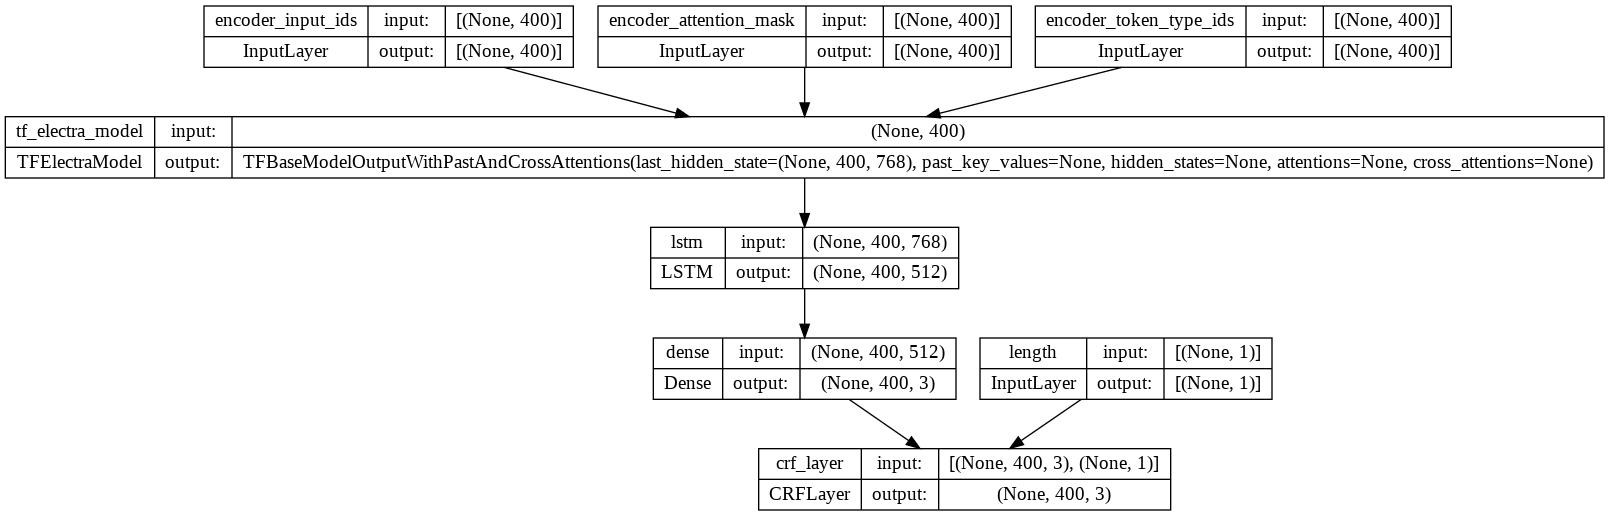

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#Evalute
model = createToxicModelWithGivenBaseModel(max_length,base_model)
train_data = createInputForNER(x_train,max_length,tokenizer)
test_data = createInputForNER(x_test,max_length,tokenizer)
spans_test = all_spans[test_index]
spans_train = all_spans[train_index]
model.fit(train_data,y_train,batch_size=16,epochs=2,callbacks=[callbacks.ModelCheckpoint("/content/drive/MyDrive/toxic span/final saved models/NER/electra/LSTM_crf/ner",save_weights_only=True)])
preds = model.predict(test_data)
indices = createIndicesForNERModel(preds,x_test,tokenizer)
f1_toxic = avg_f1(indices,spans_test)
print("test F1 = %f"%(f1_toxic))
result_test.append(f1_toxic)
preds = model.predict(train_data)
indices = createIndicesForNERModel(preds,x_train,tokenizer)
f1_toxic = avg_f1(indices,spans_train)
print("train F1 = %f"%(f1_toxic))
result_train.append(f1_toxic)


Epoch 1/2
497/497 [==============================] - 861s 2s/step - loss: 10.6817 - accuracy: 0.1115
Epoch 2/2
63/63 [==============================] - 78s 1s/step
test F1 = 0.581868
249/249 [==============================] - 294s 1s/step
train F1 = 0.613749
